Diffusion model using https://colab.research.google.com/drive/1_MEFfBdOI06GAuANrs1b8L-BBLn3x-ZJ?usp=sharing#scrollTo=yGjAU8kUZuX1

In [1]:
!pip install einops
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.7/28.7 MB 34.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 8.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid

In [13]:
is_debug = True
def log(message):
    if is_debug:
        print("**********START**********\n")
        print(message)  
        print("\n**********END********** \n\n")

This section reviews material from the [previous MLFS seminar](https://github.com/DrugowitschLab/ML-from-scratch-seminar/tree/master/DiffusionGenerativeModels) on diffusion generative models. Skip this if you already know the basics!

The gist is that our generative model will work in the following way. We will take our training examples (e.g. images) and corrupt them with noise until they are unrecognizable. Then we will learn to `denoise' them, and potentially turn pure noise into something similar to what we started with. 



**Let's start with forward diffusion.** In the simplest case, the relevant diffusion equation is
\begin{equation}
\begin{split}
x(t + \Delta t) = x(t) + \sigma(t) \sqrt{\Delta t} \ r
\end{split}
\end{equation}
where $\sigma(t) > 0$ is the 'noise strength', $\Delta t$ is the step size, and $r \sim \mathcal{N}(0, 1)$ is a standard normal random variable. In essence, we repeatedly add normally-distributed noise to our sample. Often, the noise strength $\sigma(t)$ is chosen to depend on time (i.e. it gets higher as $t$ gets larger).

In [19]:
# Simulate forward diffusion for N steps.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
  """x0: initial sample value, scalar
  noise_strength_fn: function of time, outputs scalar noise strength
  t0: initial time
  nsteps: number of diffusion steps
  dt: time step size
  """

  # Initialize trajectory
  x = np.zeros(nsteps + 1); 
  #log(f'np.zeros(nsteps + 1): {x}')
  x[0] = x0
  #log(f'x[0]: {x}')
  t = t0 + np.arange(nsteps + 1)*dt 
  
  log(f't: {t}')
  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    noise_strength = noise_strength_fn(t[i])
    ############ YOUR CODE HERE (2 lines)
    random_normal = np.random.randn()
    x[i+1] = x[i] + random_normal * noise_strength
    #####################################
  return x, t


# Example noise strength function: always equal to 1
def noise_strength_constant(t):
  return 1

**********START**********

np.zeros(nsteps + 1): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]

**********END********** 


**********START**********

x[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]

**********END********** 


**********START**********

t: [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
 

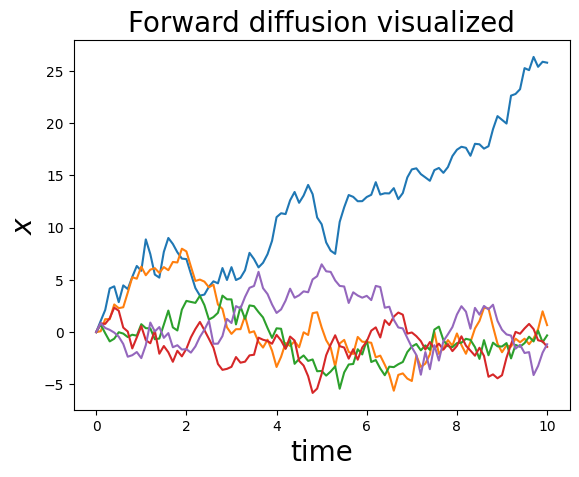

In [20]:
nsteps = 100
t0 = 0
dt = 0.1
noise_strength_fn = noise_strength_constant
x0 = 0

num_tries = 5
for i in range(num_tries):
  x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)
  
  plt.plot(t, x)
  plt.xlabel('time', fontsize=20)
  plt.ylabel('$x$', fontsize=20)
plt.title('Forward diffusion visualized', fontsize=20)
plt.show()